In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class baby_finder():
    '''
    Here is a class to analyze BABY NAMES BY STATE and YEAR
    '''
    def __init__(self, path = None):
        '''
        read data and store birth name data by state and year to dataframe
        '''
        if path == None:
            print("invalid file path. please retry")
        else:
            states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
            
            newlist = []
            names = None
            self.names = None
            columns = ['state','sex','year','name','births']

            for state in states:
                path = r'./namesbystate/%s.txt' % state
                df = pd.read_csv(path,names=columns)
                newlist.append(df)
            self.names = pd.concat(newlist,ignore_index = True)
        
    def count(self,state = None,year = None):
        '''
        This function returns the total number of births. 
        A blank state or year should return all births of the empty input.
        '''
        if state is None and year is None:
            return len(self.names)
        elif state is None:
            return len(self.names[self.names["year"]==year])
        elif year is None:
            return len(self.names[self.names["state"]==state])
        else:
            return len(self.names.loc[(self.names["state"]==state) & (self.names["year"]==year)])
    
    def Top10BabyNames(self,state = None,year = None):
        '''
        return top 10 baby names for male and female given state and year
        '''
        if state is None and year is None:
            temp = self.names

        elif state is None:
            temp = self.names[self.names["year"]==year] 
            
        elif year is None:
            temp = self.names[self.names["state"]==state]
        else:
            temp = self.names.loc[(self.names["state"]==state) & (self.names["year"]==year)]
        
        # sort female and male top 10 popular name
        f = list(dict.fromkeys(temp[temp['sex']=='F'].sort_values(by=['births'], ascending=False)['name']))[:10]
        m = list(dict.fromkeys(temp[temp['sex']=='M'].sort_values(by=['births'], ascending=False)['name']))[:10]
        
        # create rank table
        d = {'Rank':range(1,11),'Male':m,'Female':f}
        df = pd.DataFrame(d)
        display(df)
        
    def NamePopularityPlot(self,name='Jim', yearRange=(2000,2015), state='CA', sex='M'):
        '''
        This function will create a plot file that shows the name popularity changes over the year. 
        '''
        # count total number of name in each year
        num_total_name = []
        for i in range(yearRange[0],yearRange[1]+1):
            cur_len = len(self.names.loc[(self.names["state"]==state) & (self.names["year"]==i)& (self.names["sex"]==sex)])
            num_total_name.append(cur_len)
        
        #filter name state and sex
        mary = self.names.loc[(self.names['name'] == name) & (self.names['sex'] == sex) & (self.names['state'] == state) & (self.names['year'] >= yearRange[0]) & (self.names['year'] <= yearRange[1]) ]
        mary = mary[['year','births']]
        
        # calcualte percentage
        mary['births'] = mary['births']/num_total_name*100
        mary = mary.set_index(['year'])

        mary.plot(color='Blue',title='Popularity change in percentage %')
        
    def ChangeOfPopularity(self,fromYear=1996, toYear=1998, top=10):
        '''
        I define this function to compare the popularity of from year and end year. 
        If names appear in top n in from year but not in end year, I would define it as decrease popylarity
        If names not appear in top n in from year but appear in end year, I would define it as increase popylarity
        If names appear in top n in from year and also appear in end year, I would define it as same popylarity
        '''
        names = self.names
        from_names = names.loc[(names["year"]==fromYear)]
        to_names = names.loc[(names["year"]==toYear)]
        f = list(dict.fromkeys(from_names.sort_values(by=['births'], ascending=False)['name']))[:top]
        t = list(dict.fromkeys(to_names.sort_values(by=['births'], ascending=False)['name']))[:top]
        
        # initial 3 lists to store names with popularity change
        decrease = []
        increase = []
        same = []
        for name in f:
            if name not in t:
                decrease.append(name)
            else:
                same.append(name)
        for name in t:
            if name not in f:
                increase.append(name)
        print("names that increase popularity:",increase)
        print("names that decrease popularity:",decrease)
        print("names that having the same popularity:",same)
        
    def Top5NamesPerYear(self, year = 2015, sex = None):
        df = self.names
        
        # filter names according to parameters
        if sex is None:
            df = df[df["year"] == year]
        else:
            df = df[(df["year"] == year) & (df["sex"] == sex)]
        
        # count numbers of name
        df = df.groupby(["name","state"]).sum()[['births']].reset_index()
        df = df.sort_values(["state","births"], ascending = False)
        
        df_show = pd.DataFrame()
        result = []
        unique_state = df["state"].unique()
        for state in unique_state:
            state_array = list(df[df["state"]==state].iloc[0:5,[0,2]].values.flatten())
            state_array.insert(0,state)
            result.append(state_array)
        
        final_result = pd.DataFrame(data=result,columns=["State","Rank1","Num1","Rank2","Num2","Rank3","Num3","Rank4","Num4","Rank5","Num5"])
        
        return final_result.sort_values("State").reset_index(drop=True).head(2)

        
    def NameFlip(self,n=10):
        '''
        I define this function as finding the flipped names over multiple years
        This function will find the intersection names between male and female among all the years
        and then sort the top n names according to the difference in popularity.
        (eg if a name rank 2 in male list and rank 3 in female list, the rank difference will be 1 and I consider that as a huge name flip)
        '''
        # get the most popular 100 female names and males name list
        names = self.names
        f = list(dict.fromkeys(names[names['sex']=='F'].sort_values(by=['births'], ascending=False)['name']))[:1000]
        m = list(dict.fromkeys(names[names['sex']=='M'].sort_values(by=['births'], ascending=False)['name']))[:1000]

        # convert the list to dictionary with key as name and value as popularity rank
        m_dict = {k: v for v, k in enumerate(m)}
        f_dict = {k: v for v, k in enumerate(f)}

        # find shared name between male and female
        share_name = list(set(m) & set(f))

        # only keep names in share name for both female and male
        m_share_dict = {k: v for k, v in m_dict.items() if k in share_name}
        #print(m_share_dict)
        f_share_dict = {k: v for k, v in f_dict.items() if k in share_name}
        #print(f_share_dict)

        # calcualte rank change 
        rank_diff = {}
        for i in share_name:
            rank_diff[i] = abs(m_share_dict[i]-f_share_dict[i])
        #print(rank_diff)

        # find the top n rank change names
        ans = dict(sorted(rank_diff.items(), key=lambda item: item[1]))
        ans_top = list(ans.items())[:n]

        name_plot = [i[0] for i in ans_top]
        count_plot = [i[1] for i in ans_top]
        print(name_plot)
        plt.bar(name_plot, count_plot)
        plt.xticks(rotation=90)
        plt.show()

In [2]:
baby = baby_finder("namesbystate")

# Test count function

In [3]:
baby.count(state="CA",year=1980)

4324

In [4]:
baby.count(state="CA")

400762

In [5]:
baby.count(year=1980)

59574

# Test Top10BabyNames function

In [6]:
baby.Top10BabyNames(year=2000)

,Rank,Male,Female
0,1,Daniel,Emily
1,2,Anthony,Ashley
2,3,Jose,Samantha
3,4,Andrew,Jessica
4,5,Michael,Jennifer
5,6,Jacob,Alyssa
6,7,Joshua,Alexis
7,8,Christopher,Sarah
8,9,David,Hannah
9,10,Matthew,Elizabeth


In [7]:
baby.Top10BabyNames(state = 'CA',year=2000)

,Rank,Male,Female
0,1,Daniel,Emily
1,2,Anthony,Ashley
2,3,Jose,Samantha
3,4,Andrew,Jessica
4,5,Michael,Jennifer
5,6,Jacob,Alyssa
6,7,Joshua,Alexis
7,8,Christopher,Sarah
8,9,David,Hannah
9,10,Matthew,Elizabeth


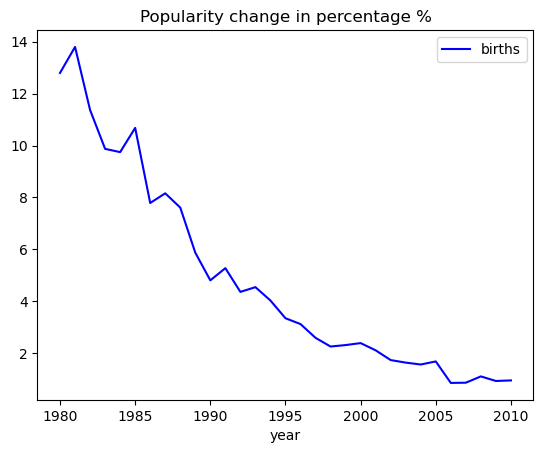

In [8]:
baby.NamePopularityPlot(name = 'Tina',yearRange=(1980,2010),sex='F')

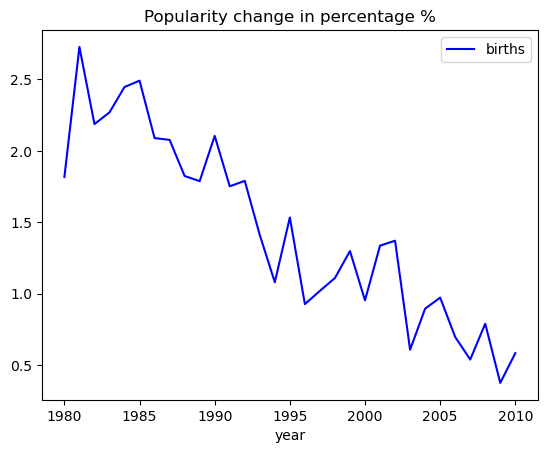

In [9]:
baby.NamePopularityPlot(name = 'Tom',yearRange=(1980,2010),sex='M')

# Story: Some names are popular in a fluctuation trend. For example, Tom is decreasing in general from 1980 to 2010 but the percentage gets up and down around every 3 years.

# Test ChangeOfPopularity function

In [10]:
baby.ChangeOfPopularity(fromYear=1980, toYear=2010, top=10)

names that increase popularity: ['Isabella', 'Sophia', 'Jacob', 'Anthony', 'Alexander', 'Angel', 'Ethan', 'Jayden']
names that decrease popularity: ['Michael', 'Jennifer', 'Christopher', 'Jason', 'Robert', 'Matthew', 'Joshua', 'James']
names that having the same popularity: ['David', 'Daniel']


In [11]:
baby.ChangeOfPopularity(fromYear=1980, toYear=2010, top=5)

names that increase popularity: ['Isabella', 'Sophia', 'Jacob', 'Anthony']
names that decrease popularity: ['Michael', 'Jennifer', 'David', 'Christopher']
names that having the same popularity: ['Daniel']


# Test Top5NamesPerYear

In [12]:
baby.Top5NamesPerYear(year = 2015)

,State,Rank1,Num1,Rank2,Num2,Rank3,Num3,Rank4,Num4,Rank5,Num5
0,AK,Olivia,56,Liam,54,Emma,49,Noah,48,Aurora,46
1,AL,William,414,James,322,John,320,Ava,298,Mason,295


In [13]:
baby.Top5NamesPerYear(year = 2000,sex = 'F')

,State,Rank1,Num1,Rank2,Num2,Rank3,Num3,Rank4,Num4,Rank5,Num5
0,AK,Hannah,58,Madison,50,Emily,48,Sarah,39,Ashley,36
1,AL,Hannah,443,Anna,386,Madison,382,Emily,371,Sarah,305


# Test NameFlip

['Jaime', 'Trinidad', 'Jody', 'Finley', 'Jessie', 'Peyton', 'Alexis', 'Jackie']


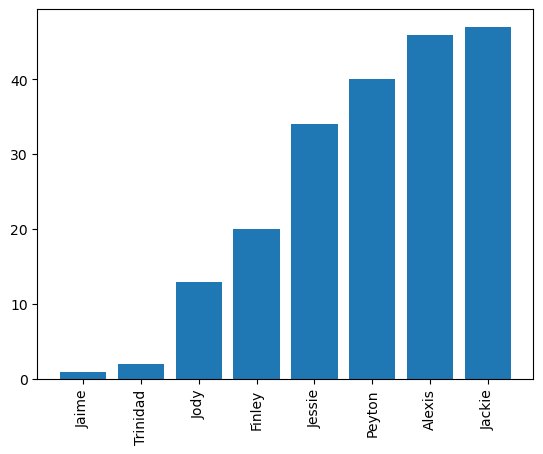

In [14]:
baby.NameFlip(n=8)